![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 002 - Part IV

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 03/04/2023 | Royi Avital | First version                                                      |
|         |            |             |                                                                    |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_03/Exercise0002Part004.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp

# Machine Learning
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering

# Computer Vision

# Statistics

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout

# My additions
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
%pip install kneed 
# !pip install kneed[plot] # To also install plotting functions for quick visualizations
from kneed import KneeLocator
import CourseAuxFun as CourseAuxFun
%load_ext autoreload
%autoreload 2



Note: you may need to restart the kernel to use updated packages.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [2]:
# Configuration
%matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [3]:
# Constants

DATA_FILE_URL   = r'https://drive.google.com/uc?export=download&confirm=9iBg&id=11YqtdWwZSNE-0KxWAf1ZPINi9-ar56Na'
DATA_FILE_NAME  = r'ClusteringData.npy'


## Guidelines

 - Fill the full names of the team memebers in the `Team Members` section.
 - Answer all questions within the Jupyter Notebook.
 - Open questions are in part I of the exercise.
 - Coding based questions are in the subsequent notebooks.
 - Use MarkDown + MathJaX + Code to answer.
 - Submission in groups (Single submission per group).
 - You may and _should_ use the forums for question.
 - Good Luck!

* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.

## Generate / Load Data

In [4]:
# Download Data
# This section downloads data from the given URL if needed.

if not os.path.exists(DATA_FILE_NAME):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

In [5]:
# Generate / Load Data

numSamples  = 1000
mA          =  np.array([[0.6, -0.6], [-0.4, 0.8]])

mX1 = datasets.make_circles(n_samples = numSamples, noise = 0.02)[0]
mX2 = datasets.make_moons(n_samples = numSamples, noise = 0.05)[0]
mX3 = datasets.make_blobs(n_samples = numSamples, random_state = 170)[0] @ mA
mX4 = datasets.make_blobs(n_samples = numSamples, random_state = 170, cluster_std = [0.8, 2, 0.4])[0] 
mX5 = np.load(DATA_FILE_NAME)

lDataSet = [mX1, mX2, mX3, mX4, mX5]
numDataSets = len(lDataSet)


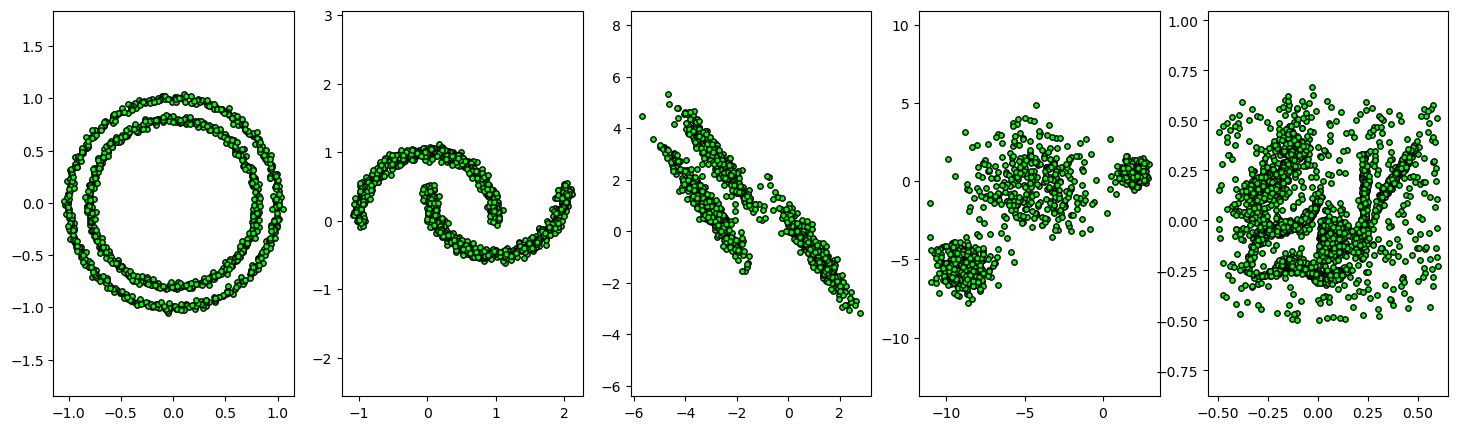

In [6]:
# Plot Data
hF, hAs = plt.subplots(nrows = 1, ncols = numDataSets, figsize = (18, 5))
hAs = hAs.flat

for ii, hA in enumerate(hAs):
    mX = lDataSet[ii]
    hA.scatter(mX[:, 0], mX[:, 1], c = 'lime', s = 15, edgecolor = 'k')
    hA.axis('equal')
    
#plt.tight_layout()
plt.show()

## 8. Clustering by Density based Spatial Clustering of Applications with Noise (DBSCAN)

### 8.1. DBSCAN Algorithm

In this section we'll implement the DBSCAN algorithm:

1. Implement an auxiliary function to compute the connected components (`GetConnectedComponents()`).  
   You may choose any implementation strategy (`DFS` / `BFS`, ect...).
2. Implement the function `DBSCAN()`.  
   The function should label noise points as `-1`.

* <font color='brown'>(**#**)</font> Implementation should be efficient (Memory and operations). Total run time expected to be **less than 20 seconds**.
* <font color='brown'>(**#**)</font> 



In [7]:
#===========================Fill This===========================#
def GetConnectedComponents(mG: np.ndarray) -> np.ndarray:
    '''
    Extract the connected components of a graph.
    Args:
        mG          - Graph matrix.
    Output:
        vL          - Label per component.
    Remarks:
        - This is a  DFS!! implementation.
    '''
    
    def dfs(node_num):
        nodes_visited[node_num] = True
        vL[node_num]            = component_num
        connected_nodes         = np.where(mG[node_num,:] == 1)[0] 
        for next_node in connected_nodes:
            if nodes_visited[next_node] == False:
                dfs(next_node)
        return
    
    number_of_nodes  = mG.shape[0]       # number of nodes in the grapgh
    vL               = np.zeros(number_of_nodes)  # Initial assignment  
    component_num    = 0
    nodes_visited    = [False] * number_of_nodes
    
    for node_num in range(number_of_nodes):
        if nodes_visited[node_num] == False:            
            dfs(node_num)
            component_num += 1
    return vL
    
            
    
#===============================================================#

In [8]:
#===========================Fill This===========================#
def DBSCAN(mX: np.ndarray, Z: int, r: float) -> np.ndarray:
    '''
    DBSCAN Algorithm.
    Args:
        mX  - Input data with shape N x d.
        Z   - Number of points required to be a core point.
        r   - Neighborhood radius.
    Output:
        vL  - The labels (-1, 0, 1, .., K - 1) per sample with shape (N, ).
    Remarks:
        - Clusters will have the labels {0, 1, ..., K - 1}.
        - Noise samples will have the label `-1`.
    '''

    # Pre
    vL = np.ones(mX.shape[0] , dtype = int )*(-1)  # initially assign all points to noise 
    
    # Step 1: Find core points
    
    # Create distance matrix between all points
    l2_dist            = pairwise_distances(mX , metric='euclidean', n_jobs=-1)
    l2_dist_r          = l2_dist <=  r
    # find core points
    core_points_check  = l2_dist_r.sum(axis = 1) >= Z
    core_points_num    = np.where(core_points_check == True)[0]
    
    # find boundary points 
    #boundry_points_check     = l2_dist_r.sum(axis = 1) >= 2 # always at least 1 as zero distance to itself
    boundry_points_check     = l2_dist_r[:,core_points_check].sum(axis = 1) >= 1 # always at least 1 as zero distance to itself
    boundry_points_check     = boundry_points_check & ~core_points_check
    boundry_points_num       = np.where(boundry_points_check == True)[0]
    
    # Step 2: Build the graph
    l2_dist_tmp         = l2_dist[core_points_check , :]
    l2_dist_core_points = l2_dist_tmp[: , core_points_check]
    mG                  = l2_dist_core_points <= r 
    
    # Step 3: Find connected components
    vL_core_points      = GetConnectedComponents(mG)
    vL[core_points_num] = vL_core_points

    # Step 4: Assign boundary points
    l2_dist_tmp            = l2_dist[boundry_points_check , :]
    l2_dist_boundary2core  = l2_dist_tmp[: , core_points_check]
    boundary_core_assign   = np.argmin(l2_dist_boundary2core , axis = 1)
    vL_boundary_points     = vL_core_points[boundary_core_assign]
    vL[boundry_points_num] = vL_boundary_points
    
    # for plot ana
    noise_points_num       = np.where(vL == -1)[0]
    
    return vL , core_points_num , boundry_points_num , noise_points_num 
#===============================================================#

### 8.2. Clustering the Data Set

In this section we'll use the implementation of the DSCAN algorithm.
The tasks are:

1. Use the data set `mX4`.
2. Tweak the parameters until you have 3 clusters.
3. Display results.

Wall time: 1.19 s


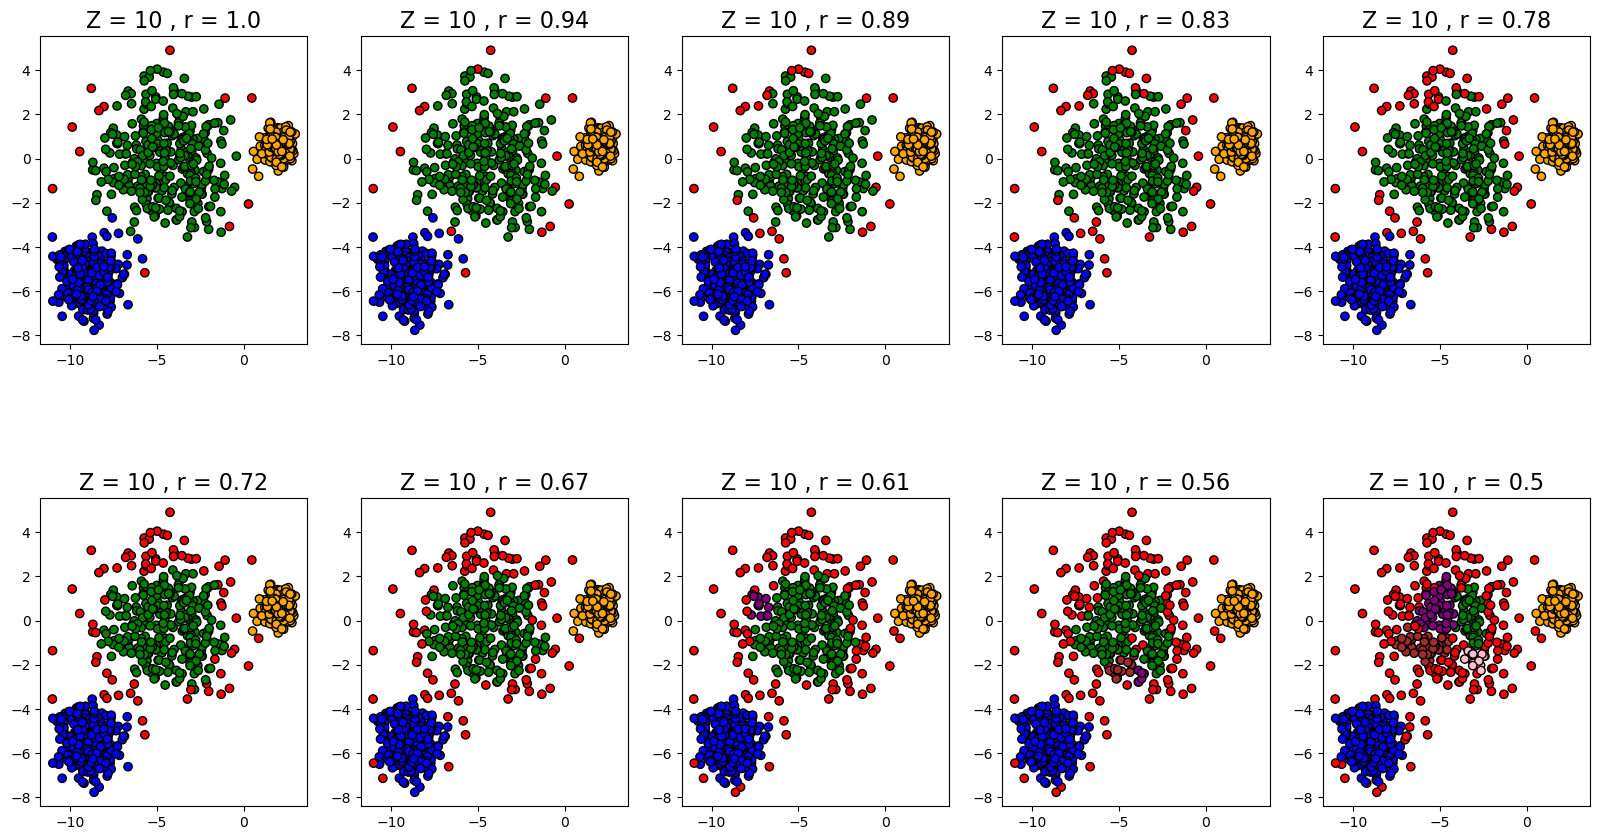

In [9]:
%%time

#===========================Fill This===========================#
# 1. Set parameters.
# 2. Apply the algorithm.

Z = 10

colors = np.array(['red' , 'blue' , 'orange' , 'green' ,  'purple' , 'brown' , 'pink' , 'gray' , 'olive' ,'cyan'])

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)

r_range = np.linspace(1,0.5,10)
for i,r in enumerate(r_range):
   
    vL ,_ , _ ,_ = DBSCAN(mX4, Z , r)
    
    ax = fig.add_subplot(2, 5, i+1)
    vL_color = colors[vL+1]  # as -1 is for noise 
    ax.set_title("Z = {} , r = {}".format(Z,round(r, 2)), fontsize=16, ha="center" )
    
    ax.scatter(mX4[:, 0], mX4[:, 1], c = vL_color, edgecolor = 'k')


Number of clusters excluding noise = 3
Number of noise samples = 47


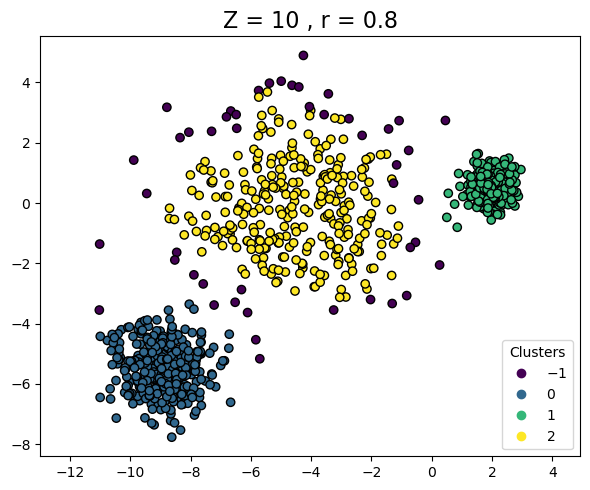

Wall time: 684 ms


In [10]:
%%time
#===========================Fill This===========================#
# 1. Plot the clustered data.
# !! The noise samples should also be labeled.


def plot_result(mX , vL , r):
    print (f'Number of clusters excluding noise = {vL.max()+1}')
    print (f'Number of noise samples = {np.count_nonzero(vL == -1)}')
    fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = (6, 5))

    #vL_color = colors[vL+1]  # as -1 is for noise 
    ax.set_title("Z = {} , r = {}".format(Z,round(r, 2)), fontsize=16, ha="center" )
    scatter = ax.scatter(mX[:, 0], mX[:, 1], c = vL, edgecolor = 'k')
    ax.axis('equal')
  
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Clusters") 
    
    plt.tight_layout()
    plt.show()
    
Z  = 10  
r  = 0.8 # After playing a little ....
vL ,_ ,_ , _ = DBSCAN(mX4, Z , r)

plot_result(mX4 , vL,r)    
#===============================================================#

### 8.3. An Algorithm to Set the Parameters Automatically Given a Data Set

Can you think about an algorithm to automatically infer optimal parameters of the DBSCAN algorithm given a data set?   

1. Sketch the algorithm (Words / Diagram).
2. Implement and test on `mX4`.
3. Plot the results.

### 8.3. Solution


Reference # 1 https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

Reference    # 2 https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd


**Pseudo code for finding suitable DBSCAN parameters $Z$ and $r$:**

Input : data

Output: $r,Z$

1. Use NearestNeighbors algorithm to find the K nearest neighbors for each point in the data. As a rule of thumb, set K to be $(2 * N)$ -1 where $N$ is number of dimensions of the data.
2. The algorithm returns sorted distances of K nearest neighbours for each point in the data.
3. Filter the results by choosing the furthest neighbour for each point and Sort their distances.
4. Plot the results, this plot describes the accumulated points per distance.
5. Choose $r$ that is found at the point of maximum curvature, This can be done by observing the graph or by using Auxiliary methods.
This point represents a "sweet spot" between large representation of data points with K nearest neighbours at distance $<=r$ with reasonable $r$. Choosing bigger $r$ beyond that point will result in adding only fewer data points while Significantly increasing the value of $r$.
6. Set $Z$ to be $2*N$  


<b>Few Notes for setting the Z parameter:    
- on General we think Z is less critical. The references  above suggest to set the  Z parameter based on following guidlines:
- The larger the data set, the larger the value of Z should be  
- If the data set is noisier, choose a larger value of Z   


<b>Algorithm limitations / assumptions:
    
- Densities across all the clusters are the same.   
- Cluster sizes or standard deviations are the same.



In [11]:
#===========================Fill This===========================#
# Implement a function which gets a data set and output the `Z` and `r` parameters of `DBSCAN()`.

#===============================================================#

def get_optimal_r(mX , Z , mode = 'MAX' , plot_en = True):
    # Generate the distance grapgh
    nearest_neighbors = NearestNeighbors(n_neighbors=Z+1)
    neighbors = nearest_neighbors.fit(mX)
    distances, indices = neighbors.kneighbors(mX)
    if mode  == 'MAX':
        distances = np.sort(distances[:,Z], axis=0)
    else:
        distances  = np.sort(distances.mean(axis = 1))
       

    # Pickup the elbow
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    r_opt = distances[knee.knee]
    if plot_en == True:
        fig = plt.figure(figsize=(5, 5))
        knee.plot_knee()
        plt.xlabel("Points")
        plt.ylabel("Distance")
    
        print  ('r = {:.3f} is optimal for Z = {}\n'.format(r_opt , Z))
    return(r_opt)

r = 0.767 is optimal for Z = 10

Number of clusters excluding noise = 3
Number of noise samples = 61


<Figure size 500x500 with 0 Axes>

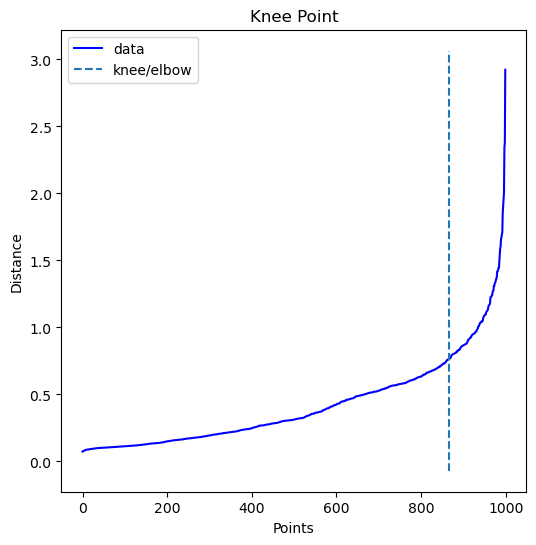

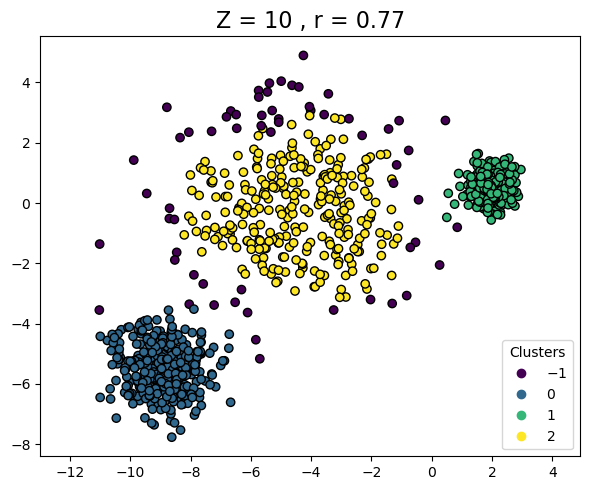

In [12]:
#===========================Fill This===========================#
# Test your algorithm on `mX4` data set. Show results.

Z        = 10
r_opt_1  = get_optimal_r(mX4 , Z = Z , mode = 'MAX' , plot_en = True)
vL_opt_1 , core_points_num , boundry_points_num , noise_points_num  = DBSCAN(mX4, Z , r_opt_1)

plot_result(mX4 , vL_opt_1,r_opt_1)    


#===============================================================#

### Analysys of the results


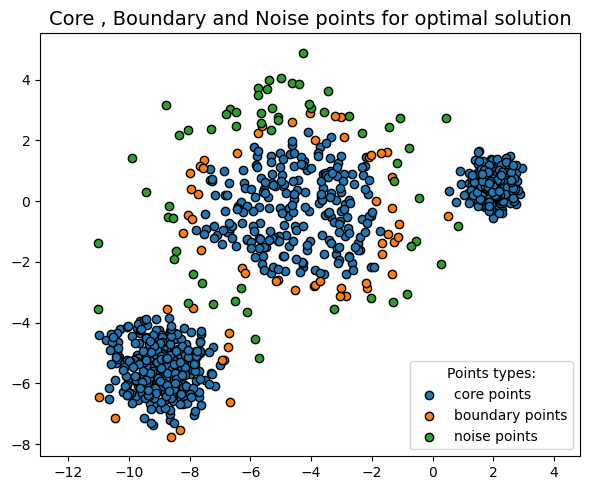

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = (6, 5))

ax.set_title("Core , Boundary and Noise points for optimal solution", fontsize=14, ha="center" )
    
ax.scatter(mX4[core_points_num, 0],    mX4[core_points_num, 1],    edgecolor = 'k' , label = 'core points')
ax.scatter(mX4[boundry_points_num, 0], mX4[boundry_points_num, 1], edgecolor = 'k' , label = 'boundary points')
ax.scatter(mX4[noise_points_num, 0],   mX4[noise_points_num, 1],   edgecolor = 'k' , label = 'noise points')
ax.axis('equal')
plt.legend(loc="lower right", title="Points types:")    
plt.tight_layout()
plt.show()

### 8.4. Test Methods on the Data Set

In this section we'll compare 4 methods on each data set.  
The 4th methods is `AgglomerativeClustering` which is imported from `SciKit Learn`.

1. Run each method on each data set.
2. Plot a grid of results (Using `plt.subplots()`): Each row is a different method, each column is a different data set.
3. Optimize the parameters per data set per method.

The final result is a grid of `4 x 5` scatter plots.

* <font color='brown'>(**#**)</font> You should use `CourseAuxFun.py` and import your self implemented functions from the module.

In [14]:
vL_dict             = {}
algo_cluster_list   = ['Kmean' , 'GMM' , 'DBSCAN' , 'Agglomerative']

for algo in algo_cluster_list:
    vL_dict[algo] = {}

In [15]:
%%time
###########
## KMEAN ##
###########
vL_list    = []
param_list = []
K_list     = [2,2,3,3,3]

for (num , mX) in enumerate(lDataSet):
    K = K_list[num]
    mC  = CourseAuxFun.InitKMeans(mX , K = K, initMethod = 1 , seedNum = 123)
    _ , vL , _ = CourseAuxFun.KMeans(mX, mC, numIter = 1000, stopThr= 5)
    vL_list.append(vL)
    param_list.append(f'K = {K}')

vL_dict['Kmean']['vL']    = vL_list
vL_dict['Kmean']['param'] = param_list

Wall time: 1.88 s


In [16]:
%%time
#############
## GMM    ##
###########

vL_list    = []
param_list = []
K_list     = [2,2,3,3,3]

for (num , mX) in enumerate(lDataSet):
    K = K_list[num]
    mμ, tΣ, vW = CourseAuxFun.InitGmm(mX,K)
    mC = mμ.copy()
    mμ, tΣ, vW, vL, _ =  CourseAuxFun.GMM(mX, mμ, tΣ, vW)
    vL_list.append(vL)
    param_list.append(f'K = {K}')
    

vL_dict['GMM']['vL']    = vL_list
vL_dict['GMM']['param'] = param_list

Wall time: 884 ms


In [17]:
%%time
#############
## DBSCAN ##
###########

vL_list    = []
param_list = []
Z_list     = [8,10,10,10,8]

for (num , mX) in enumerate(lDataSet):
    Z        = Z_list[num]
    r_opt    = get_optimal_r(mX , Z = Z , mode = 'MAX' , plot_en = False)
    vL_opt , _ , _ , _  = DBSCAN(mX, Z , r_opt)
    vL_list.append(vL_opt)
    param_list.append(f'Z = {Z}  r = {r_opt.round(2)}')

vL_dict['DBSCAN']['vL']    = vL_list
vL_dict['DBSCAN']['param'] = param_list

Wall time: 602 ms


In [18]:
%%time
#####################
## Agglomerative  ##
###################

vL_list      = [] 
K_list       = [2,2,3,3,3]
param_list   = []
linkage_list = ['single' , 'single' , 'complete' , 'ward' , 'complete']

for (num , mX) in enumerate(lDataSet): 
    K       = K_list[num]
    linkage = linkage_list[num]
    AgglomerativeClustering_inst = AgglomerativeClustering(n_clusters = K , affinity = 'euclidean' , \
                                                linkage = linkage )    
    clustering = AgglomerativeClustering_inst.fit(mX) 
    vL_list.append(clustering.labels_)
    param_list.append(f'K = {K}  linkage = {linkage}')

vL_dict['Agglomerative']['vL']    = vL_list
vL_dict['Agglomerative']['param'] = param_list

Wall time: 198 ms


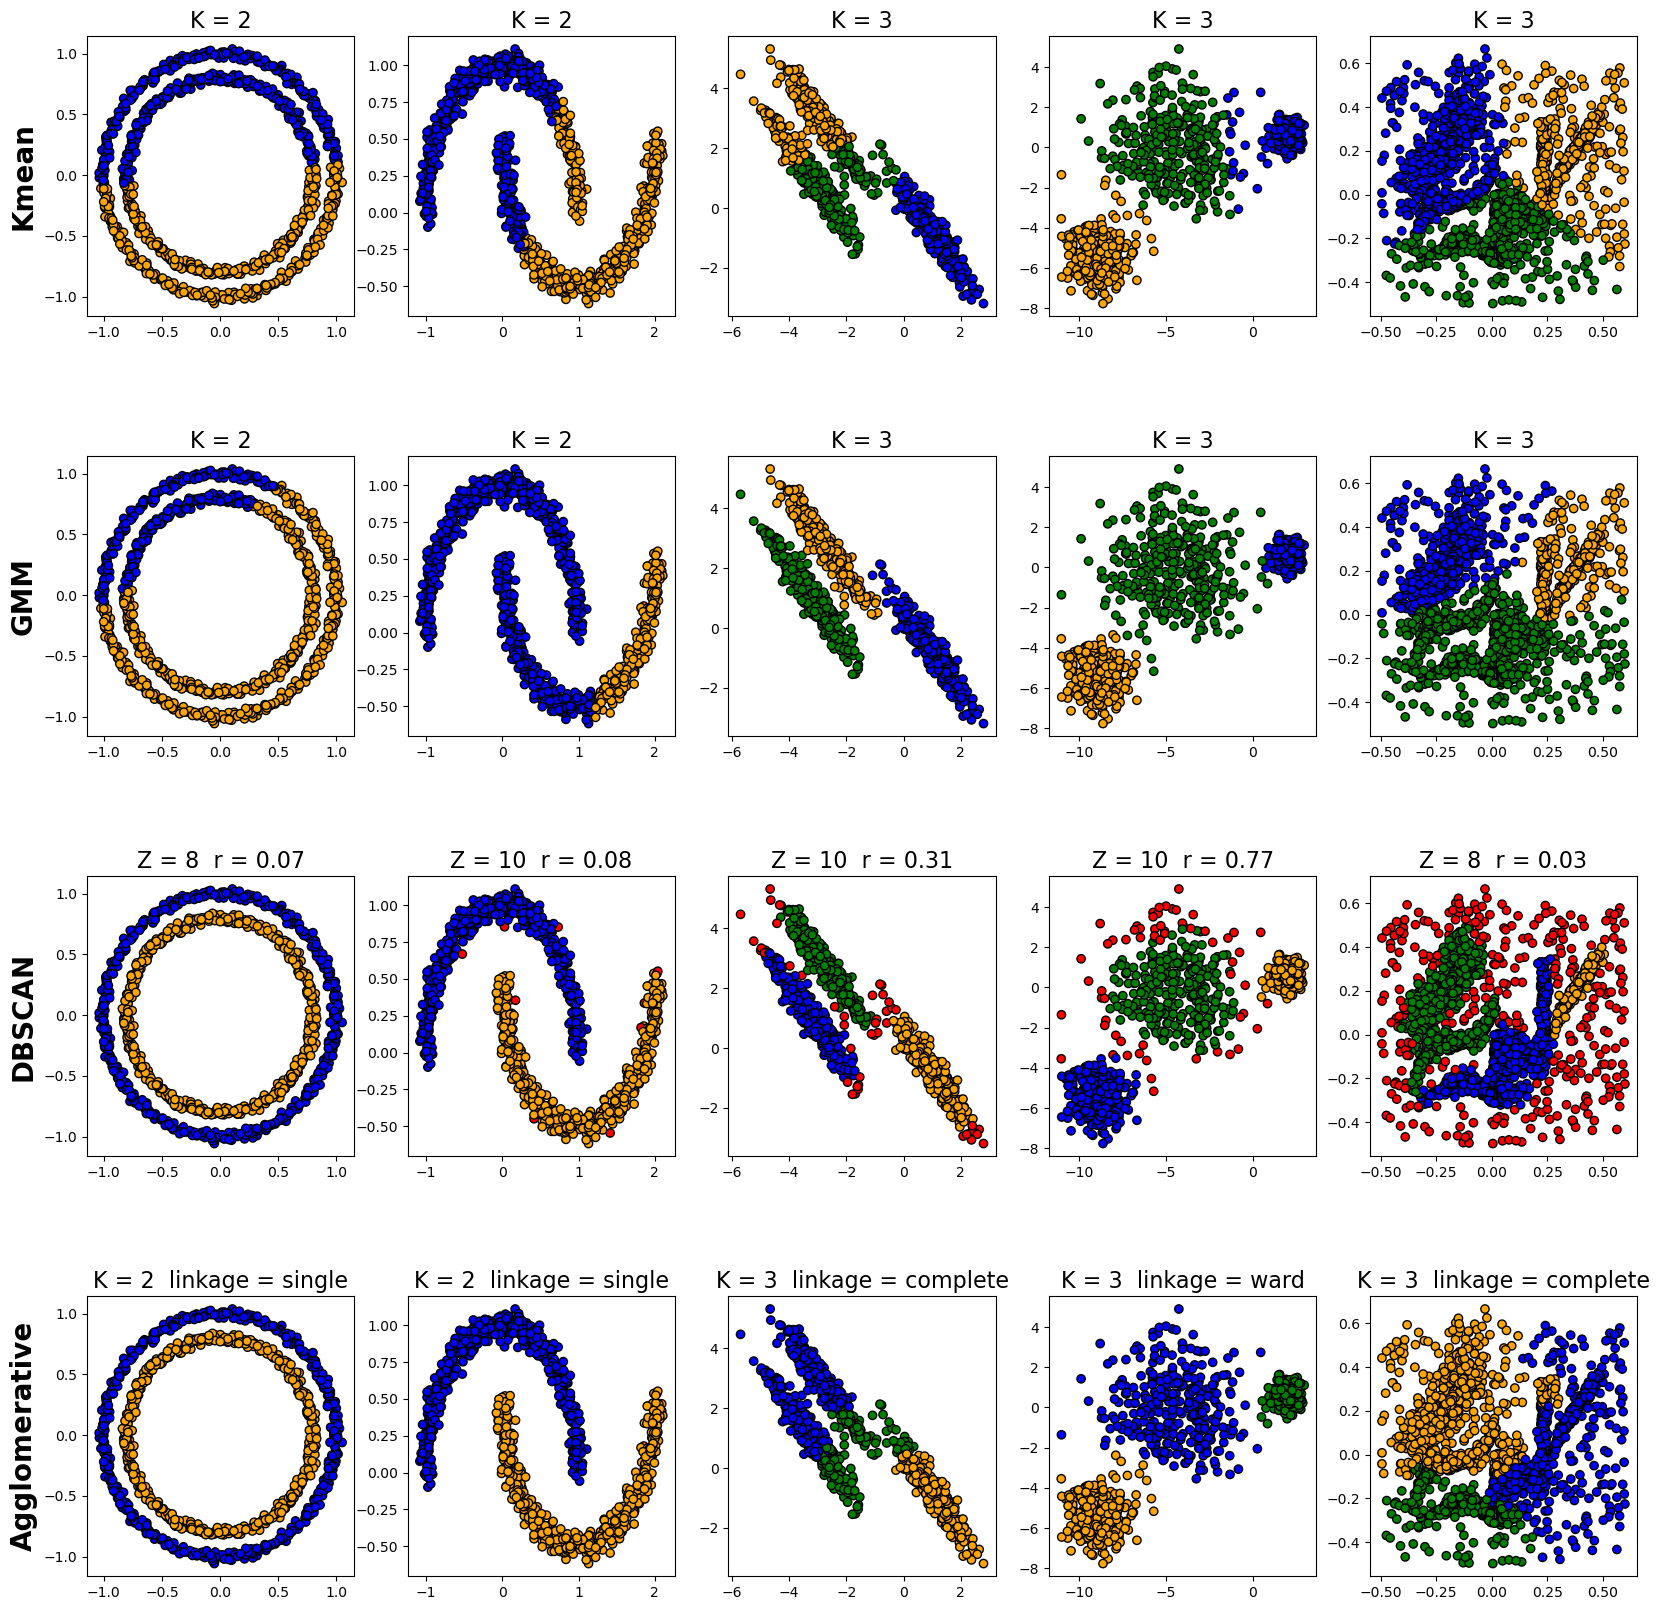

In [19]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=.5, wspace=.2)

for (algo_num , algo_name) in enumerate(algo_cluster_list):
    for (dataset_num , dataset)  in enumerate(lDataSet):
    
        fig_num  = (algo_num)*numDataSets + (dataset_num+1)
        ax       = fig.add_subplot(len(algo_cluster_list), numDataSets, fig_num)
        vL       = vL_dict[algo_name]['vL'][dataset_num] 
        param    = vL_dict[algo_name]['param'][dataset_num] 
        vL_color = colors[vL+1]  # as -1 is for noise for DBSCAN
        if dataset_num%5 == 0:
            ax.set_ylabel(f'{algo_name}', fontsize=20,fontweight="bold")
        ax.set_title(f'{param}', fontsize=16, ha="center" )
    
        ax.scatter(dataset[:, 0], dataset[:, 1], c = vL_color, edgecolor = 'k')

## More Analysis 

For the third dataset Agglomerative fails to do the desigered clustering in all linkage  options. Intuitivly the single should result by a better custering.   However  linkage = single either  creates a single cluster from 99% of the samples or two clustering if usingthe distancr threshold instead.  
For the distance threshold options seems that a few samples in the middle of thetwo clusters link together the two clusters to a single cluster 

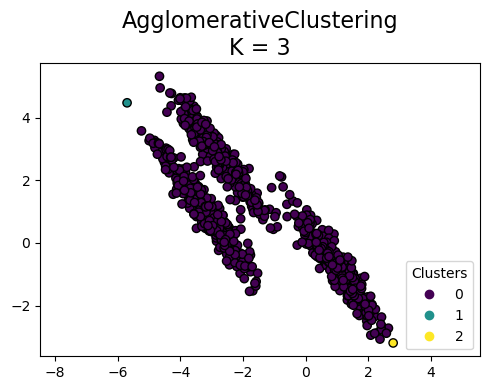

In [20]:
mX = lDataSet[2]

AgglomerativeClustering_inst = AgglomerativeClustering(affinity = 'euclidean' ,n_clusters = 3 , \
                                                linkage = 'single' )  
clustering = AgglomerativeClustering_inst.fit(mX) 
vL         = clustering.labels_

fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = (5, 4))

ax.set_title('AgglomerativeClustering\nK = 3' , fontsize=16, ha="center" )
scatter = ax.scatter(mX[:, 0], mX[:, 1], c = vL, edgecolor = 'k')
ax.axis('equal')
  
legend1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="Clusters") 
    
plt.tight_layout()
plt.show()

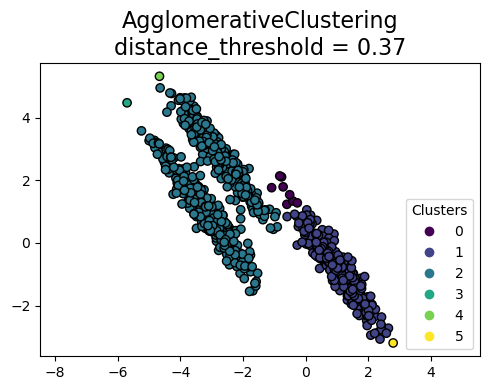

In [21]:
distance_threshold = 0.37
AgglomerativeClustering_inst = AgglomerativeClustering(affinity = 'euclidean' ,n_clusters = None , \
                                                       distance_threshold = distance_threshold, \
                                                linkage = 'single' )  
clustering = AgglomerativeClustering_inst.fit(mX) 
vL         = clustering.labels_

fig, ax = plt.subplots(nrows = 1, ncols =1, figsize = (5, 4))

ax.set_title(f'AgglomerativeClustering\ndistance_threshold = {distance_threshold}' , fontsize=16, ha="center" )
scatter = ax.scatter(mX[:, 0], mX[:, 1], c = vL, edgecolor = 'k')
ax.axis('equal')
  
legend1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="Clusters") 
    
plt.tight_layout()
plt.show()